# Anomaly Detection Challenge 1
## Miguel Sandim and Paula Fortuna

# 1 - Data Reading

In [1]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Random libraries and seeds:
import random
random.seed(2)
np.random.seed(2)

#read from csv
test_df = pd.read_csv("sat-test-data.csv.dat", header=None)
train_df = pd.read_csv("sat-train.csv.dat", header =None)


In [2]:
train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
count,3504.000000,3490.000000,3486.000000,3473.000000,3487.000000,3520.000000,3536.000000,3458.000000,3468.000000,3507.000000,...,3492.000000,3446.000000,3448.000000,3465.000000,3451.000000,3501.000000,3501.000000,3504.000000,3495.000000,4435.000000
mean,69.345034,84.036390,99.383534,82.538151,69.116719,83.565909,99.020362,82.165703,68.901961,83.196464,...,82.798969,69.247824,83.556845,99.065801,82.640104,68.885747,82.775207,99.006279,82.447496,0.108005
std,13.665657,22.757248,16.634653,18.741858,13.531984,22.835579,16.657771,18.491537,13.556329,22.699227,...,18.998009,13.535229,22.753908,16.682809,18.744963,13.409893,22.863334,16.630232,18.822432,0.310421
min,40.000000,27.000000,56.000000,33.000000,40.000000,27.000000,50.000000,29.000000,40.000000,27.000000,...,34.000000,39.000000,27.000000,50.000000,29.000000,40.000000,27.000000,50.000000,29.000000,0.000000
25%,60.000000,71.000000,85.000000,70.000000,60.000000,71.000000,85.000000,68.000000,60.000000,71.000000,...,69.750000,60.000000,71.000000,85.000000,70.000000,60.000000,71.000000,85.000000,68.000000,0.000000
50%,68.000000,87.000000,101.000000,81.000000,68.000000,86.000000,100.000000,81.000000,67.000000,85.000000,...,81.000000,68.000000,85.000000,100.000000,83.000000,67.000000,84.000000,101.000000,81.000000,0.000000
75%,80.000000,103.000000,113.000000,92.000000,79.000000,103.000000,113.000000,92.000000,80.000000,103.000000,...,92.000000,80.000000,103.000000,113.000000,92.000000,79.000000,103.000000,113.000000,92.000000,0.000000
max,104.000000,137.000000,140.000000,154.000000,102.000000,137.000000,145.000000,157.000000,104.000000,130.000000,...,154.000000,104.000000,128.000000,145.000000,157.000000,104.000000,130.000000,145.000000,157.000000,1.000000


In [3]:
train_df.iloc[:,36].value_counts()

0    3956
1     479
Name: 36, dtype: int64

In [4]:
479/(3956 + 479)

0.10800450958286359

## About 10% of our dataset are anomalous cases

# Global Variables 

In [5]:
Y_train = train_df[len(train_df.columns)-1]
X_train = train_df.drop(len(train_df.columns)-1,axis=1)
num_rows_X_train = X_train[0].count()
num_columns_X_train = len(X_train.columns)

# Utils Functions

In [6]:
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

######################################
# Function Save Data To CSV
######################################

def saveDataToCSV(Y_pred):
    id_list = range(1, len(Y_pred)+1)
    submission = pd.DataFrame({
        "Id": id_list,
        "Expected": Y_pred
    })
    submission = submission[['Id', 'Expected']]
    submission.to_csv('submission.csv', index=False)
    return


# 2 - Data Pre-Processing

## 2.1 - Missing Values

In [7]:
import scipy.stats as stats
import numpy.ma as ma
import math

######################################
# Strategies based on constants
######################################

#replace by zero - black colour in RGB
def replaceByZero(df):
    return np.nan_to_num(df)

#replace by 255 - white colour in RGB
def replaceBy255(df):
    return df.fillna(255)

#####################################
# Strategies based on columns values
#####################################

#column minimum
def replaceByColumnMinimum(df):
    return df.fillna(df.min())

#column maximum
def replaceByColumnMaximum(df):
    return df.fillna(df.max())

#column mean
def replaceByColumnMean(df):
    return df.fillna(df.mean())

#column median
def replaceByColumnMedian(df):
    return df.fillna(df.median())

#####################################
# Strategies based on rows values
#####################################

# in the analysis of the rows we have to take into account that each four consecutive rows describe a pixel.
# Each of these four rows stands for: Red, Green, IR, IR. |R|G|IR1|IR2|
# These values refer to different things, and therefore are analysed independently.
# this will allow to consider more the specificities of the problem

# divide the data into four datasets, corresponding to each type of values 

#general function to gather columns for each type |R|G|IR1|IR2| using the mod operator
def separatePixelColumns(position, df):
    indexes = range(0, num_columns_X_train-1)
    indexes = [x for x in indexes if x % 4 == position]
    df_p_attribute = df.iloc[:,indexes]
    return df_p_attribute

#general function to fill missing values based on the rows
#Note that does not make sense to consider the four values |R|G|IR1|IR2|, because they refer to different properties
def fillMissingValuesByRow(df, function):
    for index, row in df.iterrows():
        value_without_nan = function(row)
        nan_positions = row.isnull()
        row[nan_positions] = value_without_nan
    return df

#row spectral mean
def replaceByRowMean(df):
    return fillMissingValuesByRow(df, np.nanmean)

#row spectral median
def replaceByRowMedian(df):
    return fillMissingValuesByRow(df, np.nanmedian)

#row spectral minimum
def replaceByRowMinimum(df):
    return fillMissingValuesByRow(df, np.nanmin)

#row spectral maximum
def replaceByRowMaximum(df):
    return fillMissingValuesByRow(df, np.nanmax)

########################################
# Strategies based on data distribution
########################################

#consider the distribution of the spectral values of each type. 
#Get random value from the spectral values of same type

    
def getRandomNumberFromDataframe(df):
    while True:
        row = df.sample(1, random_state = 2)
        values = row.values[0]
        value = random.choice(values)
        if not math.isnan(value):
            break
    return value
        
def fillMissingValuesWithDistribution(df):
    for index, row in df.iterrows():
        nan_positions = row.isnull()
        for i in range(len(nan_positions)): 
            if nan_positions.iloc[i] == True:
                value = getRandomNumberFromDataframe(df)
                row.iloc[i] = value
    return df

#########################################%%%
# fill Missing Values Considering Spectral
#########################################%%%

def fillMissingValuesBySpectral(df, function):

    #generate four new datasets with the columns of each type
    df_p_attribute_R = separatePixelColumns(0, df)
    df_p_attribute_G = separatePixelColumns(1, df)
    df_p_attribute_IR1 = separatePixelColumns(2, df)
    df_p_attribute_IR2 = separatePixelColumns(3, df)

    #apply function to each of the 4 datasets
    df_p_attribute_R = function(df_p_attribute_R)
    df_p_attribute_G = function(df_p_attribute_G)
    df_p_attribute_IR1 = function(df_p_attribute_IR1)
    df_p_attribute_IR2 = function(df_p_attribute_IR2)

    df = pd.concat(
                        [df_p_attribute_R, 
                         df_p_attribute_G,
                         df_p_attribute_IR1,
                         df_p_attribute_IR2], 
                        axis=1
                        )
    return df

In [8]:
#######################
#   CHAMADAS
#######################

#X_train = replaceByZero(X_train)
#test_df = replaceByZero(test_df)

#X_train = replaceBy255(X_train)
#test_df = replaceBy255(test_df)

#X_train = replaceByColumnMinimum(X_train)
#test_df = replaceByColumnMinimum(test_df)

#X_train = replaceByColumnMaximum(X_train)
#test_df = replaceByColumnMaximum(test_df)

#X_train = replaceByColumnMean(X_train)
#test_df = replaceByColumnMean(test_df)

#X_train = replaceByColumnMedian(X_train)
#test_df = replaceByColumnMedian(test_df)

#X_train = fillMissingValuesBySpectral(X_train, replaceByRowMean)
#test_df = fillMissingValuesBySpectral(test_df, replaceByRowMean)

#X_train = fillMissingValuesBySpectral(X_train, replaceByRowMedian)
#test_df = fillMissingValuesBySpectral(test_df, replaceByRowMedian)

#X_train = fillMissingValuesBySpectral(X_train, replaceByRowMinimum)
#test_df = fillMissingValuesBySpectral(test_df, replaceByRowMinimum)

#X_train = fillMissingValuesBySpectral(X_train, replaceByRowMaximum)
#test_df = fillMissingValuesBySpectral(test_df, replaceByRowMaximum)

#X_train = fillMissingValuesBySpectral(X_train, fillMissingValuesWithDistribution)
#test_df = fillMissingValuesBySpectral(test_df, fillMissingValuesWithDistribution)

datasets = {f_name: {"train": f(X_train.copy()), "test": f(test_df.copy())} for f_name, f in [
        ("01-zero", replaceByZero),
        ("02-255", replaceBy255),
        ("03-col-min", replaceByColumnMinimum),
        ("04-col-max", replaceByColumnMaximum),
        ("05-col-mean", replaceByColumnMean),
        ("06-col-median", replaceByColumnMedian),
        ("07-spec-mean", lambda data: fillMissingValuesBySpectral(data, replaceByRowMean)),
        ("08-spec-median", lambda data: fillMissingValuesBySpectral(data, replaceByRowMedian)),
        ("09-spec-min", lambda data: fillMissingValuesBySpectral(data, replaceByRowMinimum)),
        ("10-spec-max", lambda data: fillMissingValuesBySpectral(data, replaceByRowMaximum)),
        ("11-spec-dis", lambda data: fillMissingValuesBySpectral(data, fillMissingValuesWithDistribution))
    ]}



## 2.2 Normalization

There is no need for normalization in this dataset, since all features are between 0 and 255.

# 3 - Model Selection

- First goal: discover which type of analyses works better
- Second Goal: tune the model

## 3.1 - Model selection based on which models do best in CV using default settings:

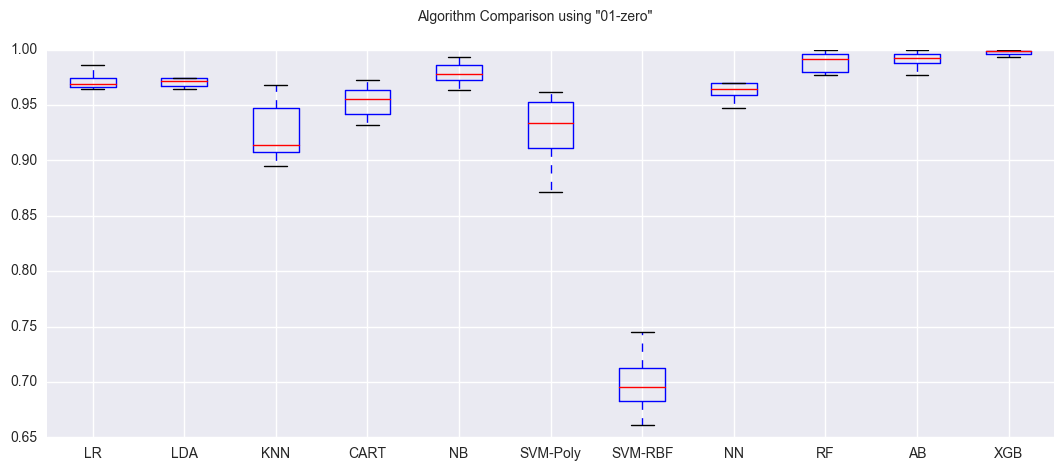

[('XGB', 0.99753973435767129), ('AB', 0.99124769555687953), ('RF', 0.98885233589259136), ('NB', 0.9790026045988206), ('LR', 0.9730223947550739), ('LDA', 0.9729599835095728), ('NN', 0.9607785603022776), ('CART', 0.9521695578189654), ('SVM-Poly', 0.92824132676980786), ('KNN', 0.92440379533733963), ('SVM-RBF', 0.69850310408374994)]


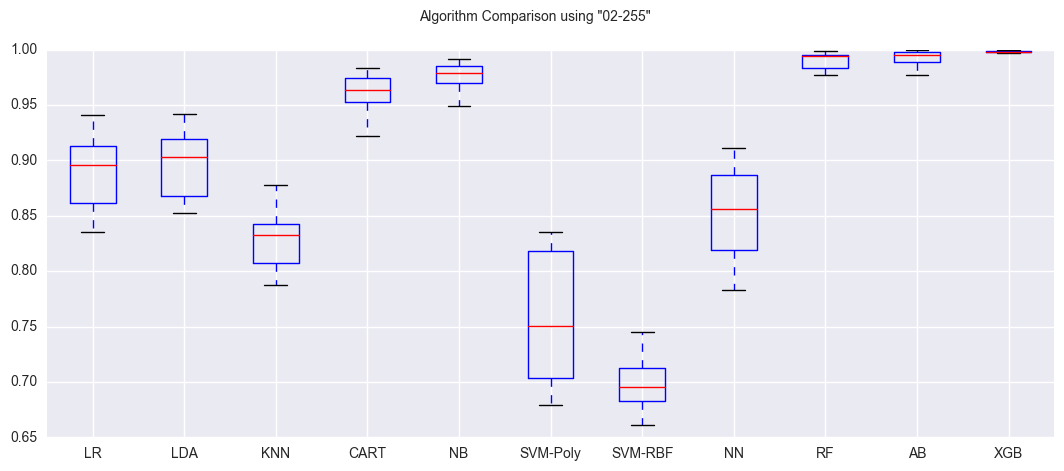

[('XGB', 0.99744138377445335), ('AB', 0.99267130355081468), ('RF', 0.99022452210293077), ('NB', 0.97687830930727504), ('CART', 0.96088135937886821), ('LDA', 0.89781357684257956), ('LR', 0.89028070197214082), ('NN', 0.85218434286758415), ('KNN', 0.82422879354071288), ('SVM-Poly', 0.7574614691556012), ('SVM-RBF', 0.69850310408374994)]


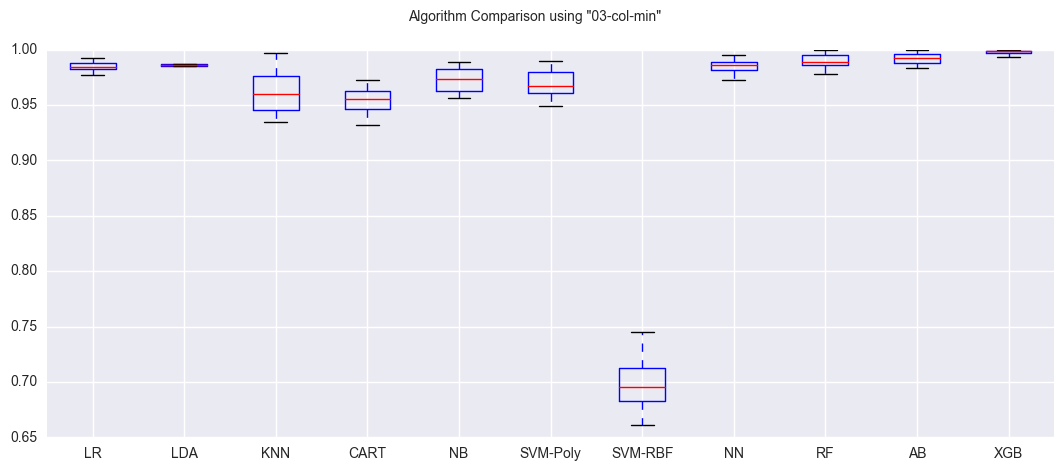

[('XGB', 0.99765063072370186), ('AB', 0.99189642973409475), ('RF', 0.98954678147055442), ('LDA', 0.98711195070826763), ('NN', 0.98569251292891202), ('LR', 0.98537257393034383), ('NB', 0.97272800979768059), ('SVM-Poly', 0.96995252399431953), ('KNN', 0.96235791458892739), ('CART', 0.95450509675260542), ('SVM-RBF', 0.69850310408374994)]


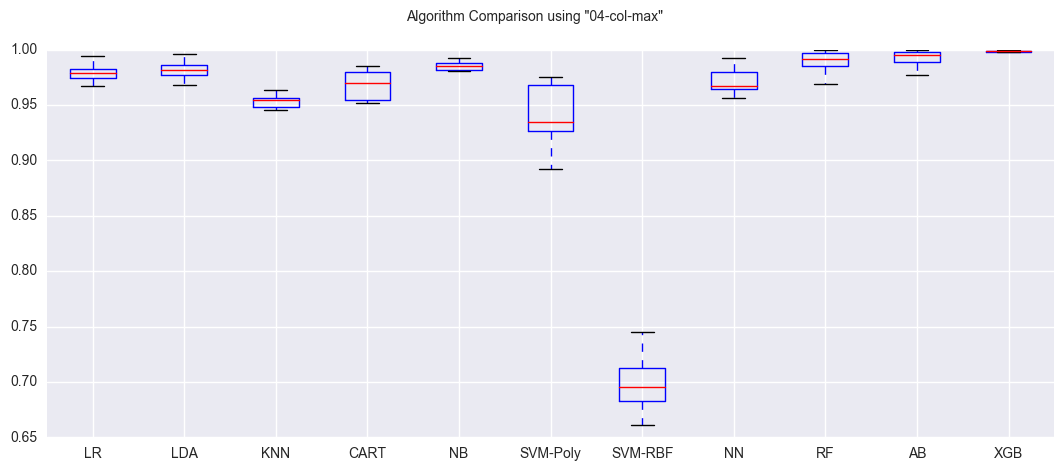

[('XGB', 0.99744980213300971), ('AB', 0.9927082367008806), ('RF', 0.98966388271688044), ('NB', 0.98387535071062548), ('LDA', 0.98169412558568891), ('LR', 0.97951802311425573), ('NN', 0.97204320422784263), ('CART', 0.96390130091651771), ('KNN', 0.95623128490103471), ('SVM-Poly', 0.94182262804451733), ('SVM-RBF', 0.69850310408374994)]


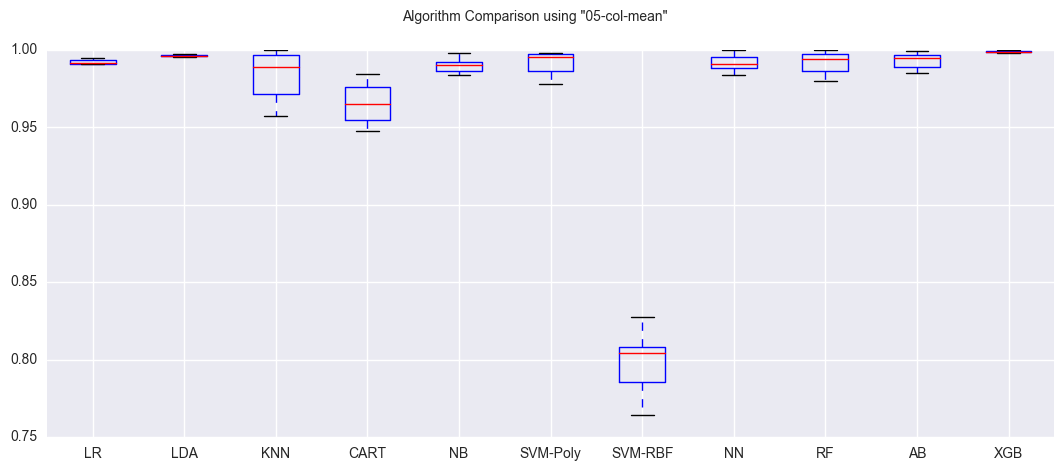

[('XGB', 0.99862348488249053), ('LDA', 0.99625055202351187), ('AB', 0.99299549551081334), ('LR', 0.99229035631927509), ('RF', 0.99216002790382496), ('NN', 0.99107777518202034), ('NB', 0.98963796070726084), ('SVM-Poly', 0.98855241327223209), ('KNN', 0.98371993809742087), ('CART', 0.96595466685437725), ('SVM-RBF', 0.79792701852441295)]


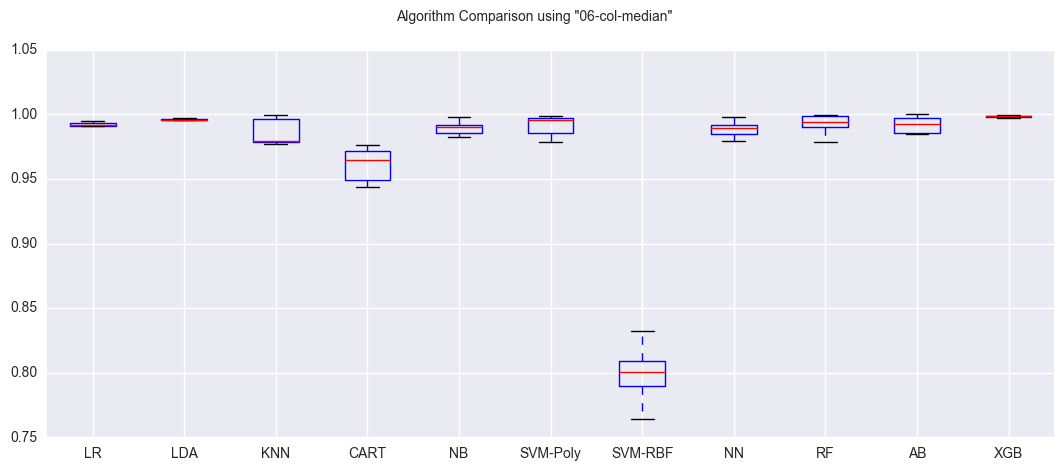

[('XGB', 0.99838974373186939), ('LDA', 0.99609148735537434), ('RF', 0.99254143534387773), ('AB', 0.99227646901731215), ('LR', 0.99210053249298791), ('NB', 0.98937983388966422), ('NN', 0.98889372901290484), ('SVM-Poly', 0.98802442460333639), ('KNN', 0.98264041772197253), ('CART', 0.96102978512569803), ('SVM-RBF', 0.79855269424313158)]


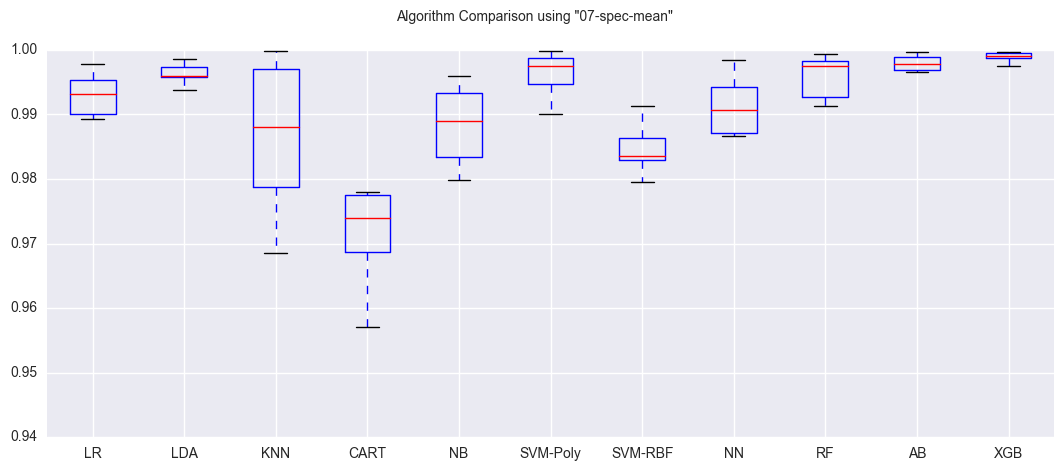

[('XGB', 0.99882405899827797), ('LDA', 0.9963258884971451), ('RF', 0.99485955181471775), ('AB', 0.99456092027193566), ('SVM-Poly', 0.99403209478300369), ('LR', 0.99310646272175018), ('NN', 0.9897825239897855), ('NB', 0.98822275888655819), ('KNN', 0.98692046004301925), ('SVM-RBF', 0.9845100710568746), ('CART', 0.97113079522670831)]


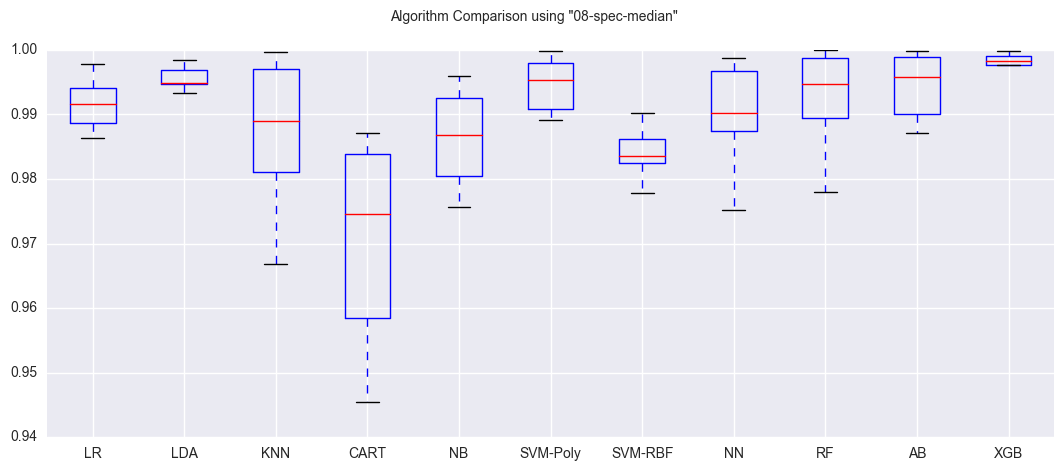

[('XGB', 0.99788193537629633), ('LDA', 0.99480758126647562), ('SVM-Poly', 0.993210610401982), ('RF', 0.99313075827400488), ('AB', 0.99298315489485023), ('LR', 0.99147535113002727), ('NN', 0.99026515831626249), ('KNN', 0.98686734846671198), ('NB', 0.9862515707732683), ('SVM-RBF', 0.98414433833577719), ('CART', 0.97021698944739609)]


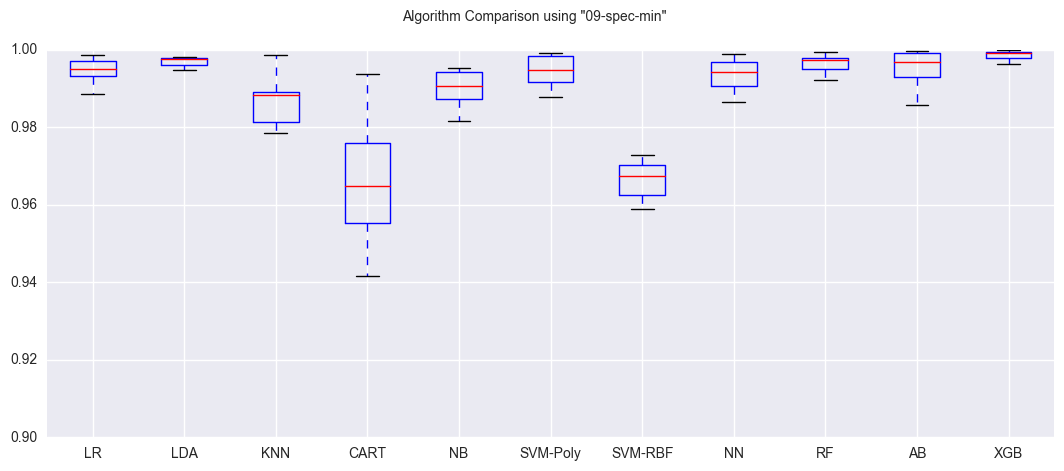

[('XGB', 0.9984619879670209), ('LDA', 0.99704691168349235), ('RF', 0.99577680674915059), ('AB', 0.99508400222260307), ('LR', 0.99469919762759118), ('NN', 0.99368033820338231), ('SVM-Poly', 0.99219092775995887), ('NB', 0.98981043489931186), ('KNN', 0.98666796596225281), ('SVM-RBF', 0.96655276052562622), ('CART', 0.96204864936736068)]


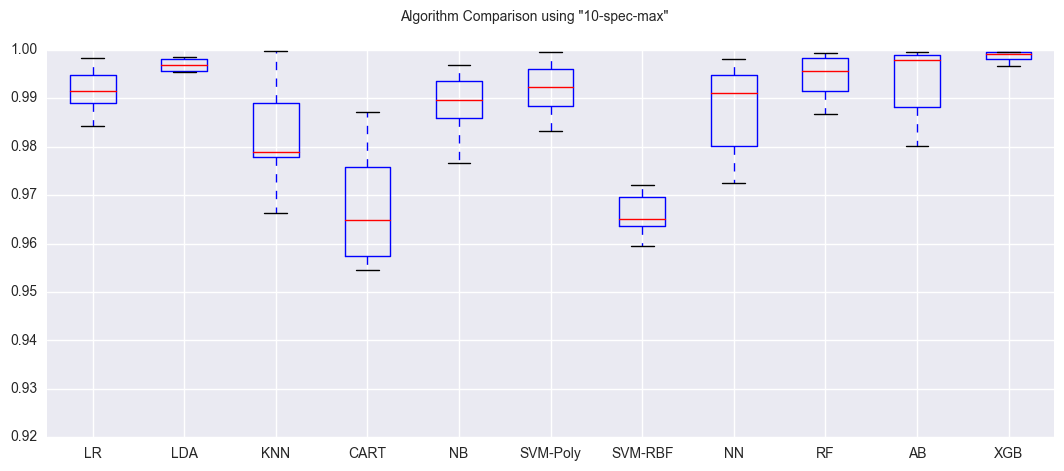

[('XGB', 0.99805118159102479), ('LDA', 0.99591861529832859), ('RF', 0.99449436006532677), ('AB', 0.99364320612081836), ('LR', 0.99167236033011685), ('SVM-Poly', 0.99025793752000657), ('NB', 0.98850730093601413), ('NN', 0.98755455426198435), ('KNN', 0.98052393053095821), ('SVM-RBF', 0.96612610855275993), ('CART', 0.96424948209539507)]


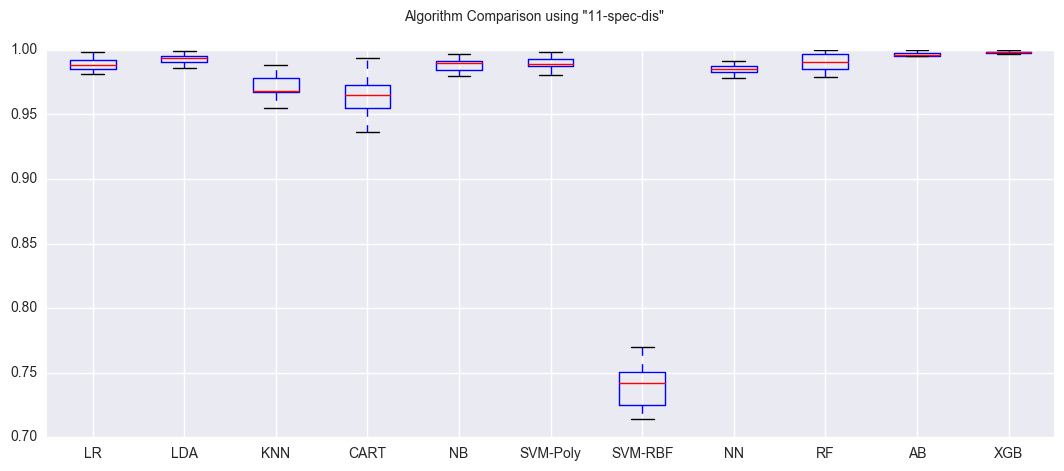

[('XGB', 0.99783917452421689), ('AB', 0.99449738684311462), ('LDA', 0.99298232515930474), ('RF', 0.99048422947039294), ('LR', 0.98885786703782608), ('SVM-Poly', 0.98855149172168777), ('NB', 0.98825503412570792), ('NN', 0.9860513939557165), ('KNN', 0.97381968815092301), ('CART', 0.96489083706714318), ('SVM-RBF', 0.74393973328649632)]


In [9]:
#inspired in http://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

import sklearn.model_selection as mds
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb

# prepare data

#Y_train = train_df[:,-1]
#X_train = train_df[:,:-1]

#Y_train = train_df[len(train_df.columns)-1]
#X_train = train_df.drop(len(train_df.columns)-1,axis=1)

# prepare configuration for cross validation test harness
num_folds = 10
num_instances = len(X_train)

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVM-Linear', SVC(kernel="linear")))
models.append(('SVM-Poly', SVC(kernel="poly")))
models.append(('SVM-RBF', SVC(kernel="rbf")))
models.append(('NN', MLPClassifier(alpha=1))) 
models.append(('RF', RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)))
models.append(('AB', AdaBoostClassifier()))
models.append(('XGB', xgb.XGBClassifier()))

# evaluate each model in turn
results = {}
scoring = 'roc_auc' # try with 'roc_auc', f1'

kfold = mds.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=2)

for NA_strategy in sorted(datasets.keys()):
    
    results_by_strategy = []
    
    for model_name, model in models:
        cv_results = mds.cross_val_score(model, datasets[NA_strategy]["train"], Y_train, cv=kfold, scoring=scoring)
        results_by_strategy.append({"name": model_name, "cv_results": cv_results, "mean": cv_results.mean(), "std": cv_results.std()})
        #print("%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std()))
        
    # boxplot algorithm comparison
    fig = plt.figure(figsize=(13, 5), dpi=500)
    fig.suptitle('Algorithm Comparison using \"%s\"' % NA_strategy)
    ax = fig.add_subplot(111)
    plt.boxplot([x["cv_results"] for x in results_by_strategy])
    ax.set_xticklabels([x["name"] for x in results_by_strategy])
    plt.show()
    
    # order the models by the mean auc
    results_by_strategy.sort(key=lambda x: x["mean"], reverse=True)
    print([(x["name"], x["mean"]) for x in results_by_strategy])
    
    results[NA_strategy] = results_by_strategy

### Results sorted by AUC

In [10]:
results_sorted = [(na_method, algorithm["name"], algorithm["mean"]) for na_method in results for algorithm in results[na_method]]
results_sorted.sort(key=lambda x: x[2], reverse=True)
results_sorted

[('07-spec-mean', 'XGB', 0.99882405899827797),
 ('05-col-mean', 'XGB', 0.99862348488249053),
 ('09-spec-min', 'XGB', 0.9984619879670209),
 ('06-col-median', 'XGB', 0.99838974373186939),
 ('10-spec-max', 'XGB', 0.99805118159102479),
 ('08-spec-median', 'XGB', 0.99788193537629633),
 ('11-spec-dis', 'XGB', 0.99783917452421689),
 ('03-col-min', 'XGB', 0.99765063072370186),
 ('01-zero', 'XGB', 0.99753973435767129),
 ('04-col-max', 'XGB', 0.99744980213300971),
 ('02-255', 'XGB', 0.99744138377445335),
 ('09-spec-min', 'LDA', 0.99704691168349235),
 ('07-spec-mean', 'LDA', 0.9963258884971451),
 ('05-col-mean', 'LDA', 0.99625055202351187),
 ('06-col-median', 'LDA', 0.99609148735537434),
 ('10-spec-max', 'LDA', 0.99591861529832859),
 ('09-spec-min', 'RF', 0.99577680674915059),
 ('09-spec-min', 'AB', 0.99508400222260307),
 ('07-spec-mean', 'RF', 0.99485955181471775),
 ('08-spec-median', 'LDA', 0.99480758126647562),
 ('09-spec-min', 'LR', 0.99469919762759118),
 ('07-spec-mean', 'AB', 0.994560920271

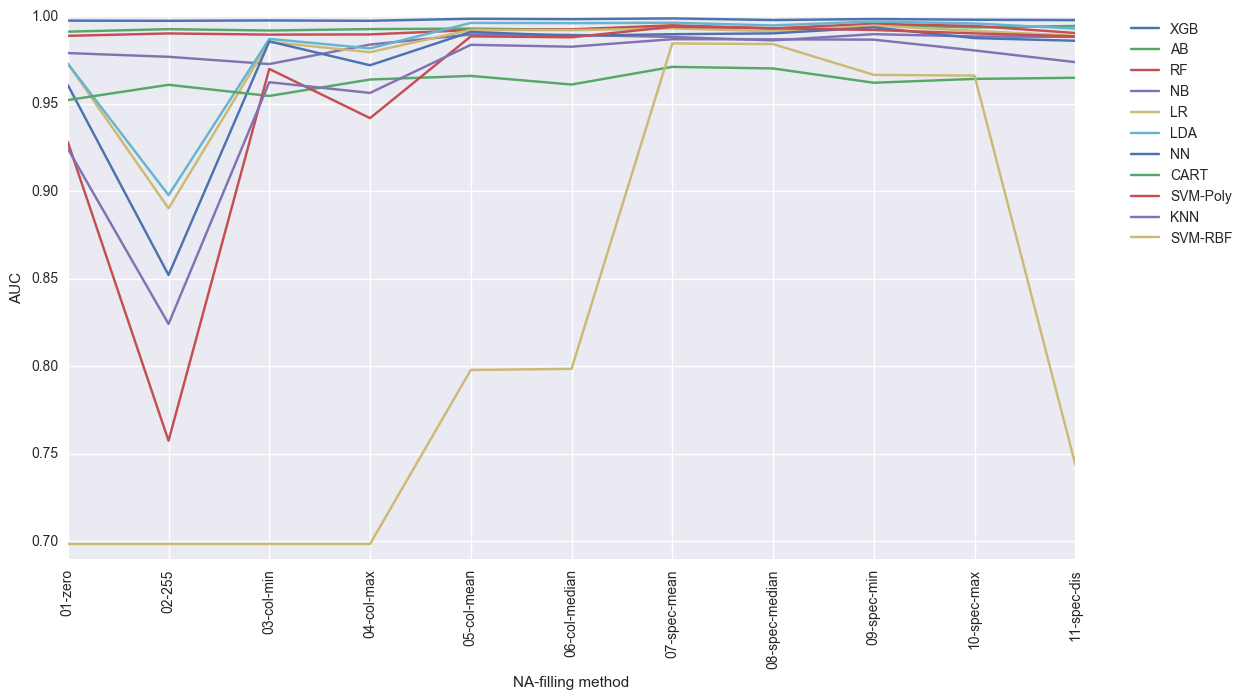

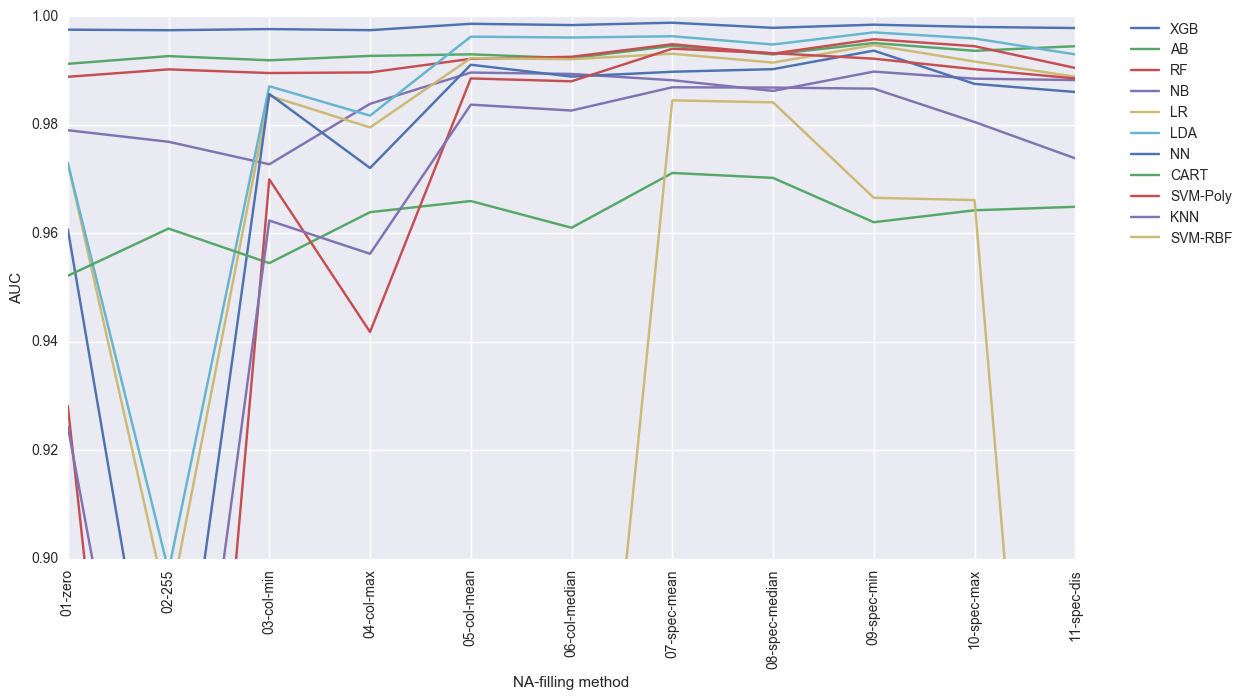

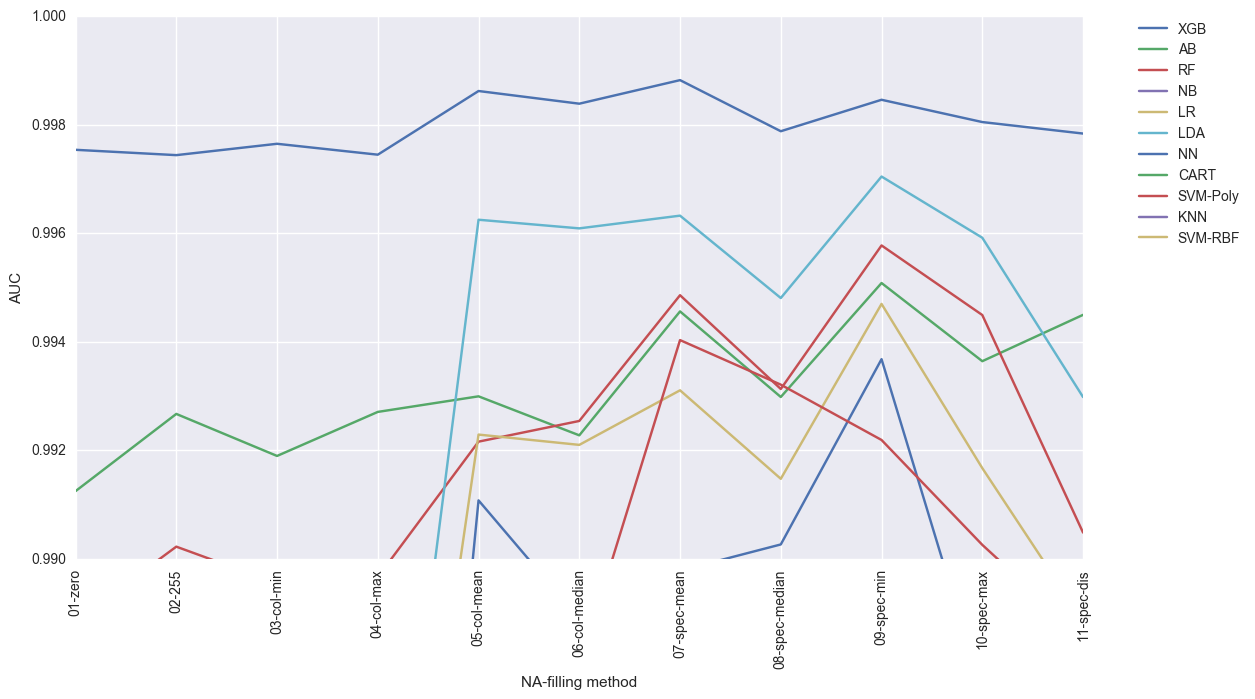

In [11]:
def plotSupervisedAlgorithmsDefault(inf, sup):
    plt.figure(figsize=(13, 7), dpi=500)
    
    # x axis
    labels = [na_method for na_method in results]
    labels.sort()
    plt.xticks(np.arange(len(labels)), labels, rotation='vertical')
    plt.ylim(inf, sup)
    
    # legend:
    algorithm_names = [x["name"] for x in results["01-zero"]] 
    
    [plt.plot([[x["mean"] for x in results[na_method] if x["name"] == alg_name] for na_method in sorted(results)],
              label = alg_name) for alg_name in algorithm_names]
    
    plt.ylabel('AUC')
    plt.xlabel('NA-filling method')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
plotSupervisedAlgorithmsDefault(0.69, 1)
plotSupervisedAlgorithmsDefault(0.9, 1)
plotSupervisedAlgorithmsDefault(0.99, 1)

### Based on this plot, we decided to tune XGB and LDA and use 07-spec-mean and 09-spec-min

Confusion matrix, without normalization
[[1975    3]
 [  23  217]]


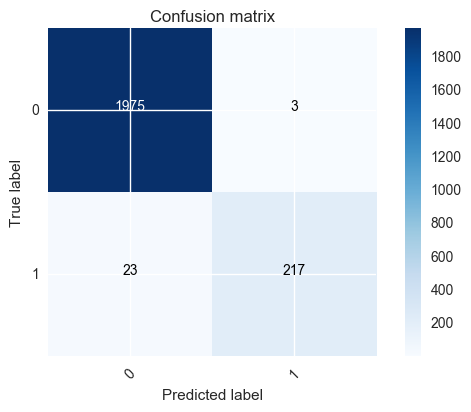

In [12]:
def plotConfusionMatrixBestXGB():
    kfold = mds.StratifiedKFold(n_splits=2, shuffle=True, random_state=2)
    train, test = kfold.split(datasets["07-spec-mean"]["train"], Y_train)

    lol = xgb.XGBClassifier().fit(datasets["07-spec-mean"]["train"].iloc[train[0]], Y_train[train[0]])

    train1_pred = lol.predict(datasets["07-spec-mean"]["train"].iloc[train[1]])

    plot_confusion_matrix(confusion_matrix(Y_train[train[1]], train1_pred, labels = [0, 1]), classes = [0, 1])
    
plotConfusionMatrixBestXGB()

Confusion matrix, without normalization
[[1975    3]
 [  16  224]]


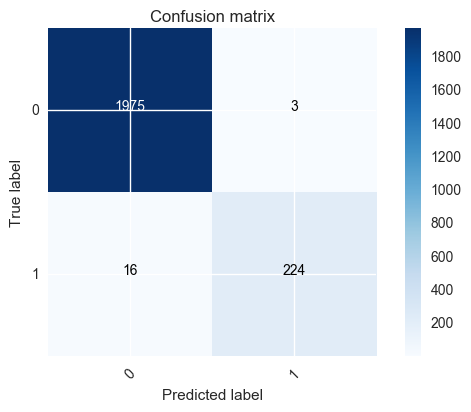

In [13]:
def plotConfusionMatrixBestLDA():
    kfold = mds.StratifiedKFold(n_splits=2, shuffle=True, random_state=2)
    train, test = kfold.split(datasets["09-spec-min"]["train"], Y_train)

    lol = xgb.XGBClassifier().fit(datasets["09-spec-min"]["train"].iloc[train[0]], Y_train[train[0]])

    train1_pred = lol.predict(datasets["09-spec-min"]["train"].iloc[train[1]])

    plot_confusion_matrix(confusion_matrix(Y_train[train[1]], train1_pred, labels = [0, 1]), classes = [0, 1])
    
plotConfusionMatrixBestLDA()

### 3.1.1 - Tuning of the best models
#### Based on this plot, we decided to tune LDA and XGB
### Tuning XGB

In [14]:
# Adapted from https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
def modelfit(alg, train_predictors, train_target, useTrainCV=True, cv_folds=10, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(train_predictors.values, label=train_target.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(train_predictors, train_target, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(train_predictors)
    dtrain_predprob = alg.predict_proba(train_predictors)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(train_target.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(train_target, dtrain_predprob))
                    
    #feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')

In [15]:
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

def tuneXGB1():
    xgb1 = xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=5, # This should be between 3-10
        min_child_weight=1, # A smaller value is chosen because it is a highly imbalanced class problem
        gamma=0,
        subsample=0.8, # Typical values range between 0.5-0.9.
        colsample_bytree=0.8, # Typical values range between 0.5-0.9.
        objective= 'binary:logistic',
        #nthread=4,
        scale_pos_weight=1, # Because of high class imbalance
        seed=2)
    
    modelfit(xgb1, datasets["07-spec-mean"]["train"], Y_train)
    
tuneXGB1()

[0]	train-auc:0.976404+0.00184872	test-auc:0.966698+0.0157154
[1]	train-auc:0.984476+0.00287929	test-auc:0.97597+0.014524
[2]	train-auc:0.988526+0.00143008	test-auc:0.980963+0.0132616
[3]	train-auc:0.990257+0.00122379	test-auc:0.983997+0.0115285
[4]	train-auc:0.990627+0.00122354	test-auc:0.986709+0.00798353
[5]	train-auc:0.990977+0.00108258	test-auc:0.986744+0.00802107
[6]	train-auc:0.991335+0.00116283	test-auc:0.988687+0.00866224
[7]	train-auc:0.991467+0.00123446	test-auc:0.988694+0.00867084
[8]	train-auc:0.991705+0.0011089	test-auc:0.989804+0.00928899
[9]	train-auc:0.991829+0.00126125	test-auc:0.990687+0.00863519
[10]	train-auc:0.992053+0.00120451	test-auc:0.990743+0.00859719
[11]	train-auc:0.992058+0.00120246	test-auc:0.990735+0.00856643
[12]	train-auc:0.992383+0.0010658	test-auc:0.990783+0.00853639
[13]	train-auc:0.992725+0.000917619	test-auc:0.990805+0.00853089
[14]	train-auc:0.992836+0.000971325	test-auc:0.990773+0.00855334
[15]	train-auc:0.992836+0.000971471	test-auc:0.990754+0.

#### This last result seems too good to be truth?!

In [16]:
def tuneXGB2():
    param_test1 = {
        'max_depth': np.arange(3,10,2),
        'min_child_weight': np.arange(1,6,2)
    }
    
    gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=156, max_depth=5,
                                                      min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                      objective= 'binary:logistic', scale_pos_weight=1, seed=2), 
                            param_grid = param_test1, scoring='roc_auc',iid=False, cv=10)
    
    gsearch1.fit(datasets["07-spec-mean"]["train"], Y_train)
    print(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)
    
tuneXGB2()

[mean: 0.99609, std: 0.00551, params: {'min_child_weight': 1, 'max_depth': 3}, mean: 0.99617, std: 0.00511, params: {'min_child_weight': 3, 'max_depth': 3}, mean: 0.99522, std: 0.00831, params: {'min_child_weight': 5, 'max_depth': 3}, mean: 0.99743, std: 0.00405, params: {'min_child_weight': 1, 'max_depth': 5}, mean: 0.99561, std: 0.00718, params: {'min_child_weight': 3, 'max_depth': 5}, mean: 0.99502, std: 0.00943, params: {'min_child_weight': 5, 'max_depth': 5}, mean: 0.99797, std: 0.00309, params: {'min_child_weight': 1, 'max_depth': 7}, mean: 0.99686, std: 0.00427, params: {'min_child_weight': 3, 'max_depth': 7}, mean: 0.99561, std: 0.00776, params: {'min_child_weight': 5, 'max_depth': 7}, mean: 0.99734, std: 0.00506, params: {'min_child_weight': 1, 'max_depth': 9}, mean: 0.99680, std: 0.00446, params: {'min_child_weight': 3, 'max_depth': 9}, mean: 0.99562, std: 0.00776, params: {'min_child_weight': 5, 'max_depth': 9}] {'min_child_weight': 1, 'max_depth': 7} 0.997969565708


C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


#### {'max_depth': 7, 'min_child_weight': 1}

In [17]:
def tuneXGB3():
    param_test1 = {
        'max_depth': [6,7,8],
        'min_child_weight': [1,2,3]
    }
    
    gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=156, max_depth=5,
                                                      min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                      objective= 'binary:logistic', scale_pos_weight=1, seed=2), 
                            param_grid = param_test1, scoring='roc_auc',iid=False, cv=10)
    
    gsearch1.fit(datasets["07-spec-mean"]["train"], Y_train)
    print(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)
    
tuneXGB3()

[mean: 0.99729, std: 0.00418, params: {'min_child_weight': 1, 'max_depth': 6}, mean: 0.99632, std: 0.00549, params: {'min_child_weight': 2, 'max_depth': 6}, mean: 0.99620, std: 0.00597, params: {'min_child_weight': 3, 'max_depth': 6}, mean: 0.99797, std: 0.00309, params: {'min_child_weight': 1, 'max_depth': 7}, mean: 0.99634, std: 0.00597, params: {'min_child_weight': 2, 'max_depth': 7}, mean: 0.99686, std: 0.00427, params: {'min_child_weight': 3, 'max_depth': 7}, mean: 0.99753, std: 0.00430, params: {'min_child_weight': 1, 'max_depth': 8}, mean: 0.99668, std: 0.00504, params: {'min_child_weight': 2, 'max_depth': 8}, mean: 0.99680, std: 0.00445, params: {'min_child_weight': 3, 'max_depth': 8}] {'min_child_weight': 1, 'max_depth': 7} 0.997969565708


C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [18]:
def tuneXGB4():
    param_test1 = {
        'gamma':[i/10.0 for i in np.arange(0,5)]
    }
    
    gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=156, max_depth=7,
                                                      min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                      objective= 'binary:logistic', scale_pos_weight=1, seed=2), 
                            param_grid = param_test1, scoring='roc_auc',iid=False, cv=10)
    
    gsearch1.fit(datasets["07-spec-mean"]["train"], Y_train)
    print(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)
    
tuneXGB4()

[mean: 0.99797, std: 0.00309, params: {'gamma': 0.0}, mean: 0.99710, std: 0.00517, params: {'gamma': 0.10000000000000001}, mean: 0.99700, std: 0.00550, params: {'gamma': 0.20000000000000001}, mean: 0.99705, std: 0.00584, params: {'gamma': 0.29999999999999999}, mean: 0.99741, std: 0.00480, params: {'gamma': 0.40000000000000002}] {'gamma': 0.0} 0.997969565708


C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


#### gamma = 0.0

In [19]:
def tuneXGB5():
    xgb1 = xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=7, # This should be between 3-10
        min_child_weight=1, # A smaller value is chosen because it is a highly imbalanced class problem
        gamma=0,
        subsample=0.8, # Typical values range between 0.5-0.9.
        colsample_bytree=0.8, # Typical values range between 0.5-0.9.
        objective= 'binary:logistic',
        #nthread=4,
        scale_pos_weight=1, # Because of high class imbalance
        seed=2)
    
    modelfit(xgb1, datasets["07-spec-mean"]["train"], Y_train)
    
tuneXGB5()

[0]	train-auc:0.98484+0.00174818	test-auc:0.973241+0.0108193
[1]	train-auc:0.99029+0.00108239	test-auc:0.97893+0.0126851
[2]	train-auc:0.991214+0.000881095	test-auc:0.983883+0.010148
[3]	train-auc:0.991573+0.00125735	test-auc:0.985673+0.0102579
[4]	train-auc:0.991703+0.00139921	test-auc:0.986668+0.00936499
[5]	train-auc:0.992051+0.00128142	test-auc:0.986683+0.00937455
[6]	train-auc:0.992292+0.000929559	test-auc:0.988837+0.0095484
[7]	train-auc:0.992295+0.000930091	test-auc:0.989745+0.00922277
[8]	train-auc:0.992413+0.000914655	test-auc:0.989817+0.00925574
[9]	train-auc:0.992413+0.000919073	test-auc:0.990678+0.00865244
[10]	train-auc:0.992524+0.000876184	test-auc:0.990681+0.00865683
[11]	train-auc:0.99252+0.000878117	test-auc:0.991683+0.00903934
[12]	train-auc:0.992737+0.000759527	test-auc:0.991687+0.00903295
[13]	train-auc:0.99296+0.000710389	test-auc:0.99167+0.00901582
[14]	train-auc:0.992954+0.000708879	test-auc:0.991675+0.00905658
[15]	train-auc:0.992946+0.000711615	test-auc:0.99164

In [20]:
def tuneXGB6():
    param_test1 = {
     'subsample': np.arange(0.6, 1.0, 0.1),
     'colsample_bytree': np.arange(0.6, 1.0, 0.1)
    }
    
    gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=156, max_depth=7,
                                                      min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                      objective= 'binary:logistic', scale_pos_weight=1, seed=2), 
                            param_grid = param_test1, scoring='roc_auc',iid=False, cv=10)
    
    gsearch1.fit(datasets["07-spec-mean"]["train"], Y_train)
    print(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)
    
tuneXGB6()

[mean: 0.99801, std: 0.00271, params: {'colsample_bytree': 0.59999999999999998, 'subsample': 0.59999999999999998}, mean: 0.99788, std: 0.00322, params: {'colsample_bytree': 0.59999999999999998, 'subsample': 0.69999999999999996}, mean: 0.99698, std: 0.00606, params: {'colsample_bytree': 0.59999999999999998, 'subsample': 0.79999999999999993}, mean: 0.99790, std: 0.00324, params: {'colsample_bytree': 0.59999999999999998, 'subsample': 0.89999999999999991}, mean: 0.99757, std: 0.00361, params: {'colsample_bytree': 0.69999999999999996, 'subsample': 0.59999999999999998}, mean: 0.99738, std: 0.00460, params: {'colsample_bytree': 0.69999999999999996, 'subsample': 0.69999999999999996}, mean: 0.99780, std: 0.00360, params: {'colsample_bytree': 0.69999999999999996, 'subsample': 0.79999999999999993}, mean: 0.99763, std: 0.00380, params: {'colsample_bytree': 0.69999999999999996, 'subsample': 0.89999999999999991}, mean: 0.99760, std: 0.00327, params: {'colsample_bytree': 0.79999999999999993, 'subsamp

C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


#### subsample = 0.6 and colsample_bytree = 0.9

In [21]:
def tuneXGB7():
    param_test1 = {
     'subsample': np.arange(0.55, 0.7, 0.05),
     'colsample_bytree': np.arange(0.85, 1.0, 0.05)
    }
    
    gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=156, max_depth=7,
                                                      min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                      objective= 'binary:logistic', scale_pos_weight=1, seed=2), 
                            param_grid = param_test1, scoring='roc_auc',iid=False, cv=10)
    
    gsearch1.fit(datasets["07-spec-mean"]["train"], Y_train)
    print(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)
    
tuneXGB7()

[mean: 0.99847, std: 0.00154, params: {'colsample_bytree': 0.84999999999999998, 'subsample': 0.55000000000000004}, mean: 0.99784, std: 0.00310, params: {'colsample_bytree': 0.84999999999999998, 'subsample': 0.60000000000000009}, mean: 0.99809, std: 0.00238, params: {'colsample_bytree': 0.84999999999999998, 'subsample': 0.65000000000000013}, mean: 0.99772, std: 0.00350, params: {'colsample_bytree': 0.90000000000000002, 'subsample': 0.55000000000000004}, mean: 0.99810, std: 0.00208, params: {'colsample_bytree': 0.90000000000000002, 'subsample': 0.60000000000000009}, mean: 0.99819, std: 0.00227, params: {'colsample_bytree': 0.90000000000000002, 'subsample': 0.65000000000000013}, mean: 0.99778, std: 0.00313, params: {'colsample_bytree': 0.95000000000000007, 'subsample': 0.55000000000000004}, mean: 0.99773, std: 0.00335, params: {'colsample_bytree': 0.95000000000000007, 'subsample': 0.60000000000000009}, mean: 0.99797, std: 0.00296, params: {'colsample_bytree': 0.95000000000000007, 'subsamp

C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


#### better tuned: subsample=0.55 and colsample_bytree=0.85

In [22]:
def tuneXGB8():
    param_test1 = {
     'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
    }
    
    gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=156, max_depth=7,
                                                      min_child_weight=1, gamma=0, subsample=0.55, colsample_bytree=0.85,
                                                      objective= 'binary:logistic', scale_pos_weight=1, seed=2), 
                            param_grid = param_test1, scoring='roc_auc',iid=False, cv=10)
    
    gsearch1.fit(datasets["07-spec-mean"]["train"], Y_train)
    print(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)
    
tuneXGB8()

[mean: 0.99847, std: 0.00154, params: {'reg_alpha': 1e-05}, mean: 0.99830, std: 0.00183, params: {'reg_alpha': 0.01}, mean: 0.99834, std: 0.00196, params: {'reg_alpha': 0.1}, mean: 0.99795, std: 0.00269, params: {'reg_alpha': 1}, mean: 0.99172, std: 0.01689, params: {'reg_alpha': 100}] {'reg_alpha': 1e-05} 0.998466926991


C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


#### Reg alpha = 1e-5

In [23]:
def tuneXGB9():    
    xgb1 = xgb.XGBClassifier( learning_rate=0.01, n_estimators=5000, max_depth=7,
                      min_child_weight=1, gamma=0, subsample=0.55, colsample_bytree=0.85,
                      reg_alpha=1e-5, objective= 'binary:logistic', scale_pos_weight=1, seed=2)
    
    modelfit(xgb1, datasets["07-spec-mean"]["train"], Y_train)
    
tuneXGB9()

[0]	train-auc:0.981798+0.00189519	test-auc:0.977048+0.0155233
[1]	train-auc:0.990197+0.000938898	test-auc:0.985856+0.013117
[2]	train-auc:0.991528+0.00102915	test-auc:0.987845+0.0130489
[3]	train-auc:0.991544+0.00104413	test-auc:0.988845+0.0129202
[4]	train-auc:0.992003+0.00105671	test-auc:0.988847+0.0130314
[5]	train-auc:0.992118+0.000929973	test-auc:0.990712+0.00987897
[6]	train-auc:0.992236+0.00103595	test-auc:0.990689+0.00990842
[7]	train-auc:0.992236+0.00103632	test-auc:0.990688+0.00990071
[8]	train-auc:0.992235+0.00104112	test-auc:0.990706+0.00987818
[9]	train-auc:0.992235+0.00104101	test-auc:0.990695+0.00982801
[10]	train-auc:0.992346+0.00102982	test-auc:0.990713+0.00984505
[11]	train-auc:0.992345+0.00102762	test-auc:0.99072+0.00980585
[12]	train-auc:0.992458+0.000965733	test-auc:0.990719+0.00981512
[13]	train-auc:0.992454+0.000971074	test-auc:0.990762+0.00975918
[14]	train-auc:0.992447+0.00096877	test-auc:0.990749+0.00978652
[15]	train-auc:0.992444+0.000970732	test-auc:0.991601

### Tuning LDA

In [24]:
def tuneLDA():
    param_test1 = [{"solver": ["svd"], "n_components": np.arange(1,len(X_train.columns) - 1)},
                   {"solver": ["lsqr", "eigen"], "n_components": np.arange(1,len(X_train.columns) - 1), "shrinkage": ["auto"]}]
        
    gsearch1 = GridSearchCV(estimator=LinearDiscriminantAnalysis(), 
                            param_grid = param_test1, scoring='roc_auc', cv=10)
    
    fit = gsearch1.fit(datasets["09-spec-min"]["train"], Y_train)
    return(fit)
    
bestLDAfit = tuneLDA()

In [25]:
bestLDAfit.best_params_

{'n_components': 1, 'shrinkage': 'auto', 'solver': 'lsqr'}

In [26]:
bestLDAfit.best_score_

0.99653896851525403

In [27]:
def evaluatingBestLDA():
    kfold = mds.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=2)
    model = LinearDiscriminantAnalysis(n_components = 1, shrinkage = "auto", solver="lsqr")
    
    cv_results = mds.cross_val_score(model, datasets["09-spec-min"]["train"], Y_train, cv=kfold, scoring="roc_auc")
    print(cv_results.mean())
    
evaluatingBestLDA()

0.997067915498


## 3.2 - Unsupervised Anomaly Detection Methods
We decided to try LOF and see how it goes. We used our implementation from HW1

In [28]:
import lof_pal as lof

Confusion matrix, without normalization
[[1182  796]
 [   3  237]]


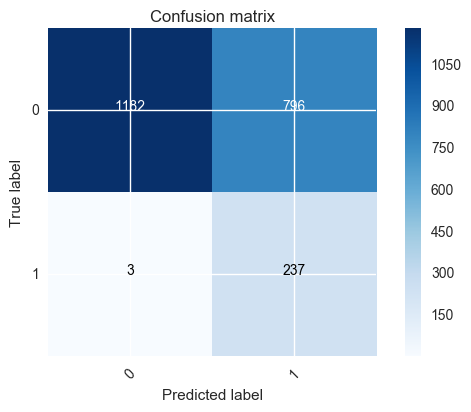

In [29]:
def makePredictonsLOF():
    outliers = []
    
    kfold = mds.StratifiedKFold(n_splits=2, shuffle=True, random_state=2)
    sets,_ = kfold.split(datasets["07-spec-mean"]["train"], Y_train)                                      
    
    # Train with only positive examples:
    l = lof.LOF(datasets["07-spec-mean"]["train"].iloc[sets[0]][Y_train[sets[0]] != 1], 3)
    
    Y_pred = [1 if x > 1.2 else 0 for x in l.predict(datasets["07-spec-mean"]["train"].iloc[sets[1]])]
        
    plot_confusion_matrix(confusion_matrix(Y_train[sets[1]], Y_pred, labels = [0, 1]), classes = [0, 1])
    #return Y_pred
        
    
makePredictonsLOF()

# 4 - Submission to Kaggle

In [30]:
# choose algorithm
def makeSubmissionKaggle(NA_strategy, algorithm):
    print("Submiting using \"%s\"" % (NA_strategy))

    algorithm.fit(datasets[NA_strategy]["train"], Y_train)
    Y_pred = algorithm.predict(datasets[NA_strategy]["test"])
    Y_pred = Y_pred.astype(int)

    # save data to CSV
    saveDataToCSV(Y_pred)
    
#makeSubmissionKaggle("07-spec-mean", xgb.XGBClassifier( learning_rate=0.01, n_estimators=5000, max_depth=7,
#                      min_child_weight=1, gamma=0, subsample=0.55, colsample_bytree=0.85,
#                      reg_alpha=1e-5, objective= 'binary:logistic', scale_pos_weight=1, seed=2))

#makeSubmissionKaggle("09-spec-min", LinearDiscriminantAnalysis(n_components = 1, shrinkage = "auto", solver="lsqr"))
makeSubmissionKaggle("10-spec-max", AdaBoostClassifier())

Submiting using "10-spec-max"
